# Experiment 1: Investigating the factors that influence topic model performance in terms for text cleanup.

The purpose of experiment 1 is to explore which factors affect building a good topic model from LDA. This is achieved by considering different pre-processing, comparing word clouds. This was achieved by manually adjusting the pre-processing during experimentation. This is the final notebook that illustrates the concepts. It is not meant to automate experimentation on a dataset.

## Pre-requisites
- The pre-process notebook must have been run to generate the pre-processed files.
- To make sure the graph library can plot inside the notebook, the jupyter labextension must be installed prior to executing this command: _jupyter labextension install jupyterlab-plotly_

## Dataset
This code in this notebook is written such that only Allen-p's emails are used. To adapt it would be easy though. 

## Support functions
The support functions below have to be loaded first. The support functions are used in the rest of the notebook. The support functions are listed here for convenience of reference and possible modification should the reader wish to experiment. 


In [4]:
import os
import re
import os
import tempfile
import math
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models import CoherenceModel
import json
from pprint import pprint

from tqdm import tqdm

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np

import plotly.graph_objects as go


################ Function definitions ###############
# A helper function which loads the json email and returns it as a dictionary
def loadMail(filename):
    with open (filename, "r") as inputFile:
        return json.load(inputFile)
################ End Function definitions ###############


########## Code: Loading Dictionaries #########
def build_dictionaries(subdir, pre_pend_filter = "", limit = 10000):
    # This technique requires dictionaries to fit in available memory.
    # It is good for experimenting, but not for general purpose use if lots of data will be processed.
    bow_docs_common = []
    texts_common = []
    bow_docs_pos = []
    texts_pos = []
    files = []
    dictionary_common = Dictionary()   # Dictionary based on common words
    dictionary_pos = Dictionary()      # Dictionary based on Part of Speech tagging


    print("Building dictionaries\n")

    # Build a dictionary of all the emails
    count = 0
    for root, dirs, files in os.walk(subdir):
        for file in files:
            if not re.search(r'^\.',file):     #Filter out common files created by the OS
                filename = os.path.basename(file)
                if pre_pend_filter == "" or re.match(pre_pend_filter, filename, flags=re.IGNORECASE) != None:
                    email_file = os.path.join(root,file)
                    #new_mail.initMail(email_file)
                    # Build a dictionary and BOW from common token documents

                    #for key, value in developer.items():
                        #print(key, ":", value)
                    email_dict = loadMail(email_file)
                    texts_common.append(email_dict['body_tokens'])
                    dictionary_common.add_documents([email_dict['body_tokens']])
                    bow_docs_common.append(dictionary_common.doc2bow(email_dict["body_tokens"]))

                    # Build a specialised POS dictionary and BOW
                    if(email_dict["body_pos_tokens"] != None):
                        texts_pos.append(email_dict["body_pos_tokens"])
                        dictionary_pos.add_documents([email_dict["body_pos_tokens"]])
                        bow_docs_pos.append(dictionary_pos.doc2bow(email_dict["body_pos_tokens"]))
                    files.append(email_file)

                    if count == limit:
                        break
                    else:
                        count = count + 1
    print("Finished building dictionaries.\n\n")

    print("Number of documents in the BOW corpus: ",len(bow_docs_common))
    print("Number of documents in the POS corpus: ",len(bow_docs_pos))
    
    return bow_docs_common,dictionary_common,texts_common,bow_docs_pos,dictionary_pos,texts_pos,files

### Define a helper function to initialise and train the LDA model #####
### The defaults fix some hyperparameters for the LDA model which can be overwritten #####
def build_LDA_model(dictionary, bow_docs, num_topics = 2, 
              chunksize = 2000, 
              passes = 20, 
              iterations = 400, 
              eval_every = None):

    dictionary[0]  # This is only to "load" the dictionary.
    id2word = dictionary.id2token

    model = LdaModel(
        corpus=bow_docs,
        id2word=id2word,
        chunksize=chunksize,
        alpha='auto',
        eta='auto',
        iterations=iterations,
        num_topics=num_topics,
        passes=passes,
        eval_every=eval_every)
    return model

#Define a general helper function to take the trained model and plot a wordcloud of the topics.
def plot_wordcloud(model,filename = ''):
    # Extract the topic words and related frequecies.
    topics = model.show_topics(formatted=False)

    # Define a square mask to print the wordcloud.
    x, y = np.ogrid[:500, :500]
    mask = (x - 250) ** 2 + (y - 250) ** 2 > 250 ** 2
    mask = 255 * mask.astype(int)

    # For each topic, extract the word and frequencies, build a wordcloud and display it.
    for topic_nr,topic in zip(range(0,len(topics)+1),topics):
        topic_words = dict(topic[1])
        cloud = WordCloud(mask=mask,background_color="white").generate_from_frequencies(topic_words)
        plt.figure()
        plt.imshow(cloud)
        plt.axis("off")
        plt.title("Topic nr : " + str(topic_nr + 1))
        plt.show()
        if filename != '':
            topic_filename = filename + '_topic_' + str(topic_nr + 1) + '.png'
            print('Saving: ',topic_filename)
            cloud.to_file(topic_filename)

# Helper function to score topics in a range and retain the models in memory
def score_topics(dictionary, bow_docs, texts, start=1, stop=2, step=1, show_progress = True,
                store_models = False,prefix=''):
    
    scores = []
    num_topics_list = list(range(start,stop))   # Build a list of integers from start to stop
    num_topics_subset = num_topics_list[::step] # Pick the subset with step size
    
    with tqdm(total=len(num_topics_subset)) as pbar:
        for num_topics in num_topics_subset:
            model = build_LDA_model(dictionary, bow_docs, num_topics)   #Build the model
            coherence_model_lda = CoherenceModel(model=model, texts = texts, 
                                                 dictionary = dictionary, 
                                                 coherence='c_v')       # Build the coherence model
            coherence_lda = coherence_model_lda.get_coherence()         # Get the coherence score
            scores.append((num_topics, coherence_lda, model))           # Save the coherece score with the associated number of topics
            #if store_models:
            #    with tempfile.NamedTemporaryFile(mode='w+b', prefix=prefix + '_'+str(num_topics)+'_',
            #                                     dir=tmpdir,delete=False) as tmp:
            #        lda.save(tmp.name)
            pbar.update(1)
    
    if store_models:
        tmpdir = tempfile.mkdtemp(prefix = prefix + '_',dir = '.')     #Create a directory to save the models
        score_pairs = {}
        for score in scores:
            num_topics,score,model = score       #Extract the three elements
            with tempfile.NamedTemporaryFile(mode='w+b', prefix=prefix + '_'+str(num_topics)+'_',
                                             dir=tmpdir,delete=False) as tmp:
                    model.save(tmp.name)
            score_pairs[num_topics] = score
        
        with tempfile.NamedTemporaryFile(mode='w', prefix=prefix + '_scores_', suffix = '.json',
                                         dir=tmpdir,delete=False) as tmp:
            print(score_pairs)
            json.dump(score_pairs,tmp)

    return scores

# Helper function which uses plotly to plot the scores
def plot_topic_scores(scores,reference = 0):
    x = []
    y = []
    min = 1
    max = 0

    # Extract the scores as x,y pairs
    for entry in scores:
        x.append(entry[0])
        y.append(entry[1])
        if entry[1] > max:
            max = entry[1]
        if entry[1] < min:
            min = entry[1];

    no_steps = len(x)
    step_size = x[1] - x[0]
    title = 'No of models: ' + str(no_steps) + ' -- Spacing:' + str(step_size)

    fig = go.Figure(data=go.Scatter(x=x, y=y,name='Candidate topic models'))
    if reference != 0:
        index = x.index(reference)
        value = round(y[index],5)
        marker_name = 'No of topics: ' + str(reference) + '\n -- Score: ' + str(value)
        fig.add_scatter(x=[reference]*1, y=[value], name=marker_name)
    fig.update_layout(
        title={
            'text' : title,
            'y':0.9,
            'x':0.4,
            'xanchor': 'center',
            'yanchor': 'top'},
        xaxis_title="Number of topics",
        yaxis_title="Topic coherence score",
        legend_title="",
        font=dict(family="Arial")
    )
    fig.show()









def vectorise(topic_scores,nr_topics):
    vector = [0] * nr_topics
    
    for score in topic_scores:
        vector[score[0]] = score[1]
    return vector

def dot_product(vector1,vector2):
    dot_product_sum = 0
    vector1_sum = 0
    vector2_sum = 0
    
    for v1,v2 in zip(vector1,vector2):
        dot_product_sum = dot_product_sum + (v1*v2)
        vector1_sum = vector1_sum + v1*v1
        vector2_sum = vector2_sum + v2*v2
        
    vector_product = dot_product_sum / (math.sqrt(vector1_sum) * math.sqrt(vector2_sum))
    return vector_product

def cosine_sim(vector1,vector2):
    vector_product = round(dot_product(vector1,vector2),7)
    angle_radians = math.acos(vector_product)
    return math.degrees(angle_radians)





## Demonstration of code and background into building and representing the LDA model

The below code builds the model with a basic LDA model with only two topics.  Determining the number of topics is either a guess, or techniques used later in the notebook. The below code is included to illustrate the basics of executing code based on the support functions, and not needed specifically for the experiment. This section can be skipped if the only interest is in the actual experimental results.

In [2]:
########## Initialisation Section ##########
# Set the location of the directory used for processing
maildir_path = os.path.join('..','..','data', 'processed', 'experimental_data')
subdir = os.path.join(maildir_path,'allen-p') 

########## End Initialisation Section ##########


# Build the dictionaries
bow_docs_common,dictionary_common,texts_common,bow_docs_pos,dictionary_pos,texts_pos,files = build_dictionaries(subdir, pre_pend_filter = "Basic_")
####### Set hyperparameters of the models and initialise the models #####
num_topics_common = 2


# Define and train the LDA models
print('Training topics for common model\n')
model_common = build_LDA_model(dictionary_common, bow_docs_common,num_topics = num_topics_common)


# Report some basics to illustrate the result of training the model
# Print the top topics for subjective evaluation
# Extract the top topics from the models
top_topics_common = model_common.top_topics(bow_docs_common) 

print("Common BOW topics")
pprint(top_topics_common)


# Compute some statistics on topic coherence
print("Computing topic coherence")
# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence_common = sum([t[1] for t in top_topics_common]) / num_topics_common

print('Average topic coherence for common BOW: %.4f.' % avg_topic_coherence_common)

Building dictionaries

Finished building dictionaries.


Number of documents in the BOW corpus:  3034
Number of documents in the POS corpus:  3034
Training topics for common model

Common BOW topics
[([(0.0076445793, 'image'),
   (0.0072367843, 'would'),
   (0.0067264508, 'phillip'),
   (0.006142888, 'please'),
   (0.004831792, 'price'),
   (0.004724637, 'cost'),
   (0.00459993, 'wa'),
   (0.004539215, 'gas'),
   (0.00415004, 'need'),
   (0.0041260067, 'loan'),
   (0.003997294, 'time'),
   (0.0039615696, 'get'),
   (0.0037710178, 'new'),
   (0.0035660071, 'ha'),
   (0.0035197637, 'allen'),
   (0.0033965618, 'project'),
   (0.0033450155, 'email'),
   (0.003279409, 'pm'),
   (0.003271171, 'subject'),
   (0.0032026642, 'power')],
  -1.3391287060773416),
 ([(0.09562857, 'ect'),
   (0.06488311, 'enron'),
   (0.056188714, 'hou'),
   (0.017750895, 'ee'),
   (0.013882409, 'phillip'),
   (0.013097687, 'allen'),
   (0.012370011, 'corp'),
   (0.012164725, 'na'),
   (0.012163695, 'k'),
   (0.00958

### Interpretation on the LDA model

Each topic consists of keywords with associated wheights.  The higher the weigth of a word, the more it will contribute to classifying a piece of text to belong to the particular topic.  With only two topics selected, where there may be many topics within the corpus, the topics are probably not very accurate.

Topic coherence as it is presented here, still requires further investigation.

### Alternative representation
Below is an alternative representation of some of the words in the topic models. The word sizes are proportional to their weight.  Notice that there is no topic heading. Topic modelling is an unsupervised training model and not deterministic, i.e. running the model twice may group different words or result in different weights assigned to the words in a model.

The visual representation is useful in an "eyeball" approach as to how well the topic words are grouped, and especially useful to determine how well the preprocess has filtered unwanted words.  This will be illustrated later in the Notebook.

Wordcloud of topics for the common dictionary.



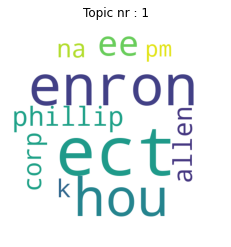

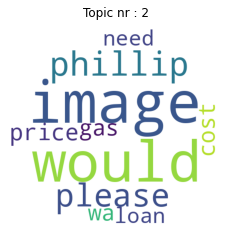

In [3]:
print("Wordcloud of topics for the common dictionary.\n")
plot_wordcloud(model_common)

## Experiment 1

### Conducting a search for the number of topics

Topic coherence is used to conduct a search for the number of topics.  %Still need to study this in more detail%.
The basic idea is keeping the model hyperparameters fixed, and iterating through the number of topics.  The lower limit and step can be adjusted as required.  Plotting a graph of the scores makes it easier to evaluate the performance of the model across topics.


100%|███████████████████████████████████████████| 18/18 [17:03<00:00, 56.88s/it]


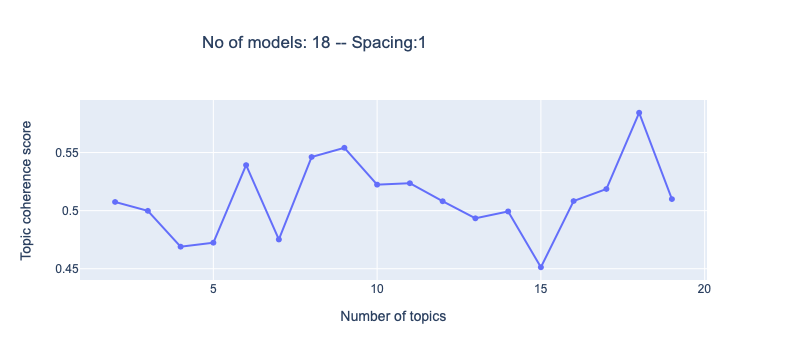

In [5]:
common_scores = score_topics(dictionary_common, bow_docs_common, texts_common, start = 2, step = 1, stop = 20)
    
plot_topic_scores(common_scores)        

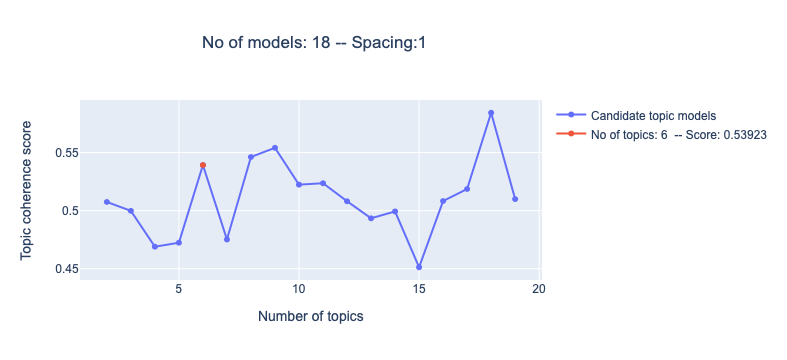

In [6]:
plot_topic_scores(common_scores, reference = 6)  

### Interpretation

The graph above varies.  By hovering over a point, the exact score can be seen. There does not seem to be much to learn from this. One can decide to pick the point with the highest topic coherence score, or perhaps plot word clouds for more that one and see if one can learn something more.

No of topics:  3 




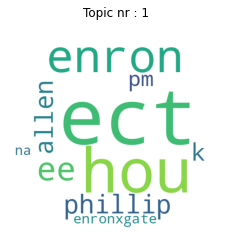

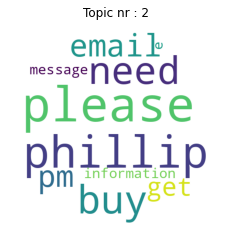

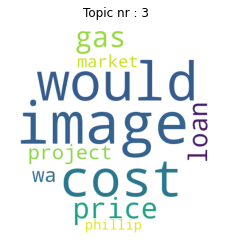

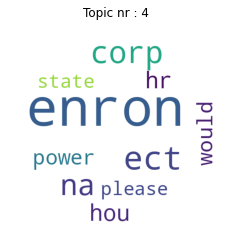


-------------------

No of topics:  6 




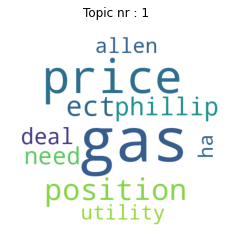

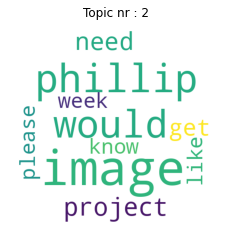

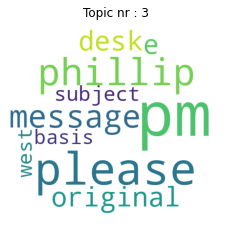

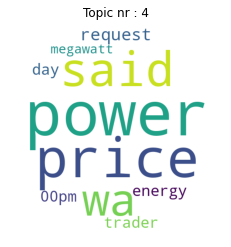

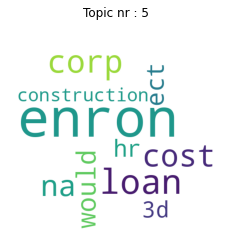

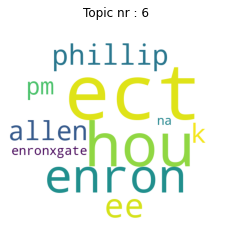

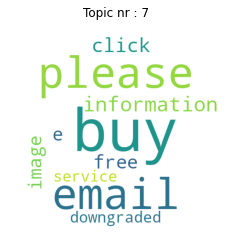


-------------------



In [10]:
plot_list = [3,6]

for nr_topics in plot_list:
    print("No of topics: ",nr_topics,"\n\n")
    plot_wordcloud(common_scores[nr_topics - 1][2])
    print('\n-------------------\n')


It is very difficult to assess based on the above.  For now, the only advantage is that there is a way to select number of topics from a graph. Repeating the above code will yield different results.  Alternatively, given the great variation in topic scores, one can pick an arbitrary number of topics for easy interpretation.

The results in the mini-disseration used 6 as the number of topics. In that case, the above graph produced the best score on 6 topics. The rest of the code still references the number of topics to be 6. This can easily be changed.

## Experiment 1a : Experimenting with pre-processing for optimisation

For the purposes of experimenting with pre-processing, a seperate directory "experimental_data" was created.  Files pre-processed in this directory has different pre_pend strings to the names:
1. very_Basic: Almost no pre-rocessing is performed. Only html is removed, and tokenise, lemmatise and lower case.
1. Basic_: Only basic pre-processing was performed.
1. Mailer_ : The javamailer style email addresses were filtered out.
1. Name_ : The name of the person who the mails belong to was filtered out.

Each pre-process includes the previous pre_processes filters.  For the basic experiments we fix the number of topics at 6 (an arbitratruy choice), and use wordclouds to subjectively assess the quality of the pre-processing by considering how well the words group together, and how many words we spot which are clearly not supposed to be used in topic classification.

### Very basic pre_processing


Building dictionaries

Finished building dictionaries.


Number of documents in the BOW corpus:  3034
Number of documents in the POS corpus:  3034
Training topics for common model

Wordcloud of topics for the basic pre-processing.



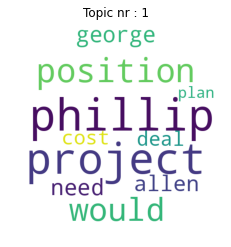

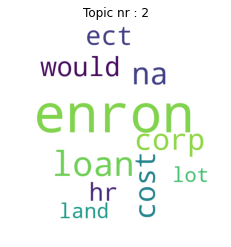

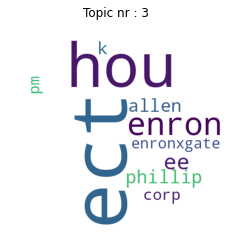

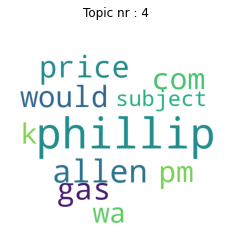

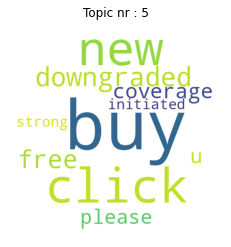

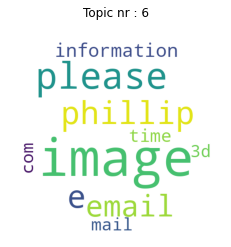

In [9]:
maildir_path = os.path.join('..','..','data', 'processed', 'experimental_data')
subdir = os.path.join(maildir_path,'allen-p')

bow_docs_common,dictionary_common,texts_common,_,_,_,_ = build_dictionaries(subdir, pre_pend_filter = "very_Basic_")

####### Set hyperparameters of the models and initialise the models #####
num_topics = 6


# Define and train the LDA models
print('Training topics for common model\n')
model_common_basic = build_LDA_model(dictionary_common, bow_docs_common, num_topics = num_topics)

print("Wordcloud of topics for the basic pre-processing.\n")
plot_wordcloud(model_common_basic)



In [8]:
# This code can be uncommented should one wish to save the above word clouds.
#plot_wordcloud(model_common_basic,filename = 'Experiment1_Wordcloud_very_basic')

Notice that there is almost no coherence in the topic models. Phillip Allen, the mailbox owner, features rather large compared to other names.

### Basic processing


Building dictionaries

Finished building dictionaries.


Number of documents in the BOW corpus:  3034
Number of documents in the POS corpus:  3034
Training topics for common model

Wordcloud of topics for the basic pre-processing.



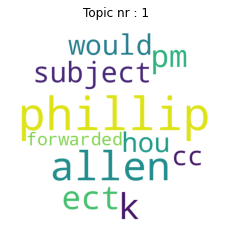

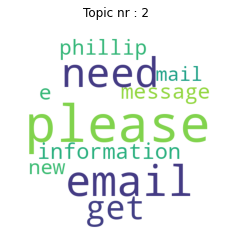

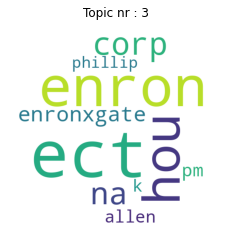

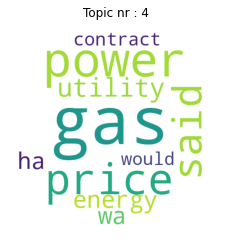

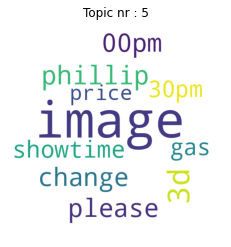

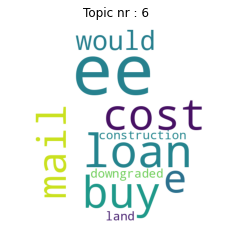

In [11]:
maildir_path = os.path.join('..','..','data', 'processed', 'experimental_data')
subdir = os.path.join(maildir_path,'allen-p')

bow_docs_common,dictionary_common,texts_common,_,_,_,_ = build_dictionaries(subdir, pre_pend_filter = "Basic_")

####### Set hyperparameters of the models and initialise the models #####
num_topics = 6


# Define and train the LDA models
print('Training topics for common model\n')
model_common_basic = build_LDA_model(dictionary_common, bow_docs_common, num_topics = num_topics)

print("Wordcloud of topics for the basic pre-processing.\n")
plot_wordcloud(model_common_basic)


In [12]:
# This code can be uncommented should one wish to save the above word clouds.
# plot_wordcloud(model_common_basic,filename = 'Experiment1_Wordcloud_basic')

It is clear from the wordclouds that "ECT", "HOU" and "Enron" dominate many of the topics.   Upon closer inspection of the actual emails, these terms occur in the email address format used by the javamailer.  This type of information is of no consequence and should be removed.

### Filtering out the javamailer addresses

Building dictionaries

Finished building dictionaries.


Number of documents in the BOW corpus:  3034
Number of documents in the POS corpus:  3034
Training topics for common model

Wordcloud of topics for the basic pre-processing and additionally filtering out java mailer addresses.



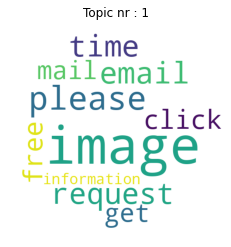

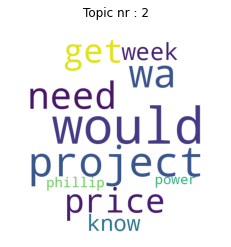

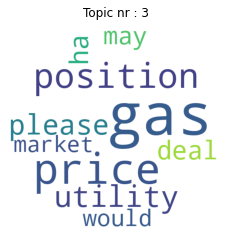

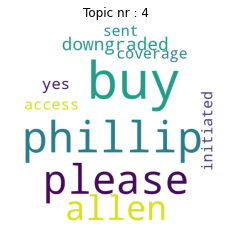

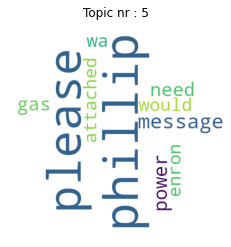

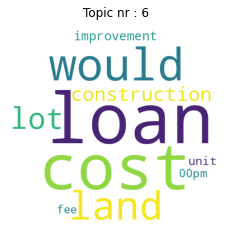

In [13]:
maildir_path = os.path.join('..','..','data', 'processed', 'experimental_data')
subdir = os.path.join(maildir_path,'allen-p')

bow_docs_common,dictionary_common,texts_common,_,_,_,_ = build_dictionaries(subdir, pre_pend_filter = "Mailer_")

####### Set hyperparameters of the models and initialise the models #####
num_topics = 6


# Define and train the LDA models
print('Training topics for common model\n')
model_common = build_LDA_model(dictionary_common, bow_docs_common, num_topics = num_topics)

print("Wordcloud of topics for the basic pre-processing and additionally filtering out java mailer addresses.\n")
plot_wordcloud(model_common)



In [14]:
# This code can be uncommented should one wish to save the above word clouds.
# plot_wordcloud(model_common,filename = 'Experiment1_JavamailerFilter')

Notice that the mailbox owner name and surname tend to dominate.  This is probably due to the mailbox owner's name or surname appear in his message signature, as this is the sent mail doirectory of Phillap Allen.

It seems necessary to filter out the name of the mailbox owner, which is the next filter that we apply.

### Filtering the mailbox owner name

Building dictionaries

Finished building dictionaries.


Number of documents in the BOW corpus:  3034
Number of documents in the POS corpus:  3034
Training topics for common model

Wordcloud of topics for the basic pre-processing, as well as java mailer and mailbox owner.



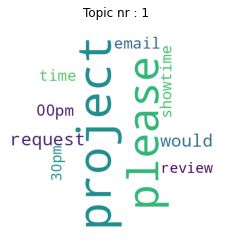

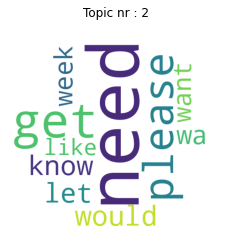

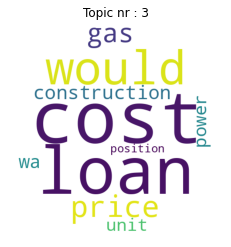

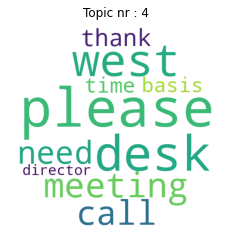

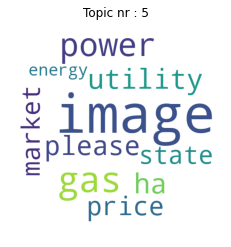

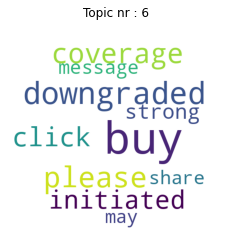

In [20]:
maildir_path = os.path.join('..','..','data', 'processed', 'experimental_data')
subdir = os.path.join(maildir_path,'allen-p')

bow_docs_common,dictionary_common,texts_common,bow_docs_pos,dictionary_pos,texts_pos,files = build_dictionaries(subdir, pre_pend_filter = "Name_")

####### Set hyperparameters of the models and initialise the models #####
num_topics = 6


# Define and train the LDA models
print('Training topics for common model\n')
model_common = build_LDA_model(dictionary_common, bow_docs_common, num_topics = num_topics)

print("Wordcloud of topics for the basic pre-processing, as well as java mailer and mailbox owner.\n")
plot_wordcloud(model_common)

In [21]:
# This code can be uncommented should one wish to save the above word clouds.
#plot_wordcloud(model_common,filename = 'Experiment1_MailboxOwner')

The topics visually seem to be improving in terms of word groupings.  To confirm, we repeat this for the "all_documents" folder as well.

Building dictionaries

Finished building dictionaries.


Number of documents in the BOW corpus:  628
Number of documents in the POS corpus:  628
Training topics for common model

Wordcloud of topics for the basic pre-processing.



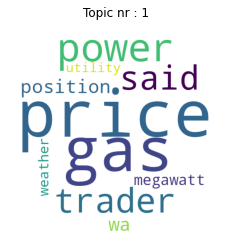

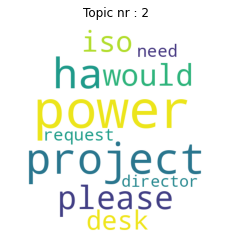

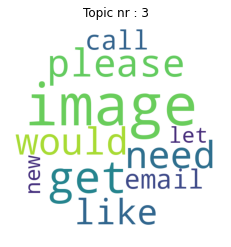

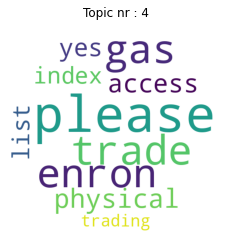

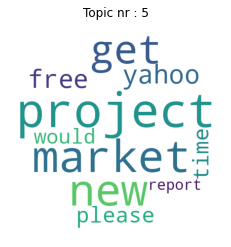

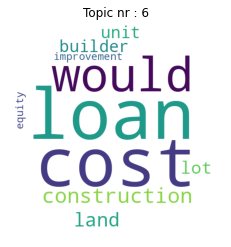

In [22]:
maildir_path = os.path.join('..','..','data', 'processed', 'experimental_data')
subdir = os.path.join(maildir_path,'allen-p','all_documents')

bow_docs_common,dictionary_common,texts_common,bow_docs_pos,dictionary_pos,texts_pos,files = build_dictionaries(subdir, pre_pend_filter = "Name_")

####### Set hyperparameters of the models and initialise the models #####
num_topics = 6


# Define and train the LDA models
print('Training topics for common model\n')
model_common = build_LDA_model(dictionary_common, bow_docs_common, num_topics = num_topics)

print("Wordcloud of topics for the basic pre-processing.\n")
plot_wordcloud(model_common)



In [23]:
# This code can be uncommented should one wish to save the above word clouds.
#plot_wordcloud(model_common,filename = 'Experiment1_MailboxOwner_all_documents')

Indeed, the topics seem to improve.

## Experiment 1b: Comparing Part of Speech tagging vs General Processing

Another method to extract the words was already applied, namely Part of Speech tagging (POS) and extracting only proper nouns, nouns and verbs for topic training.  Below is a wordcloud for the same data based on these topics.


Building dictionaries

Finished building dictionaries.


Number of documents in the BOW corpus:  3034
Number of documents in the POS corpus:  3034
Training topics for common model

Training topics for POS model

Wordcloud of topics for the common pre-processing.



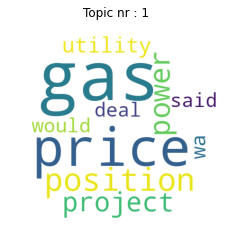

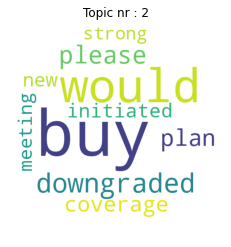

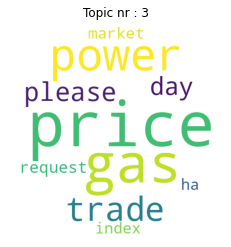

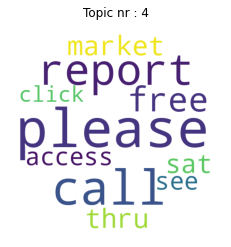

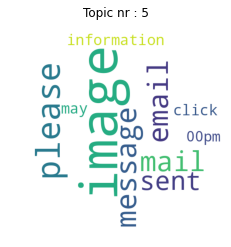

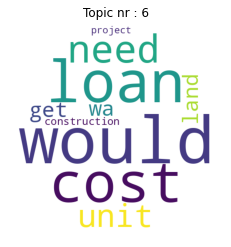

Wordcloud of topics for the POS pre-processing.



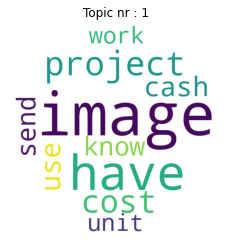

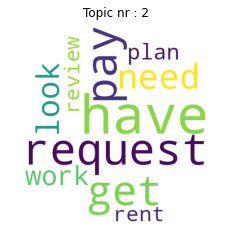

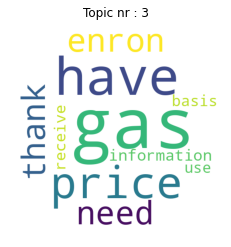

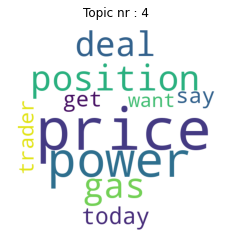

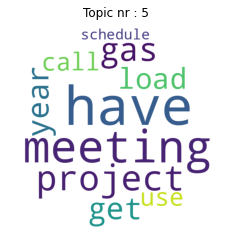

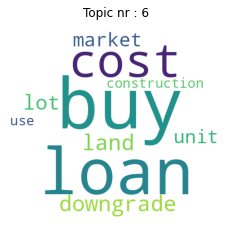

In [26]:
# Define and train the LDA models

maildir_path = os.path.join('..','..','data', 'processed', 'experimental_data')
#subdir = os.path.join(maildir_path,'allen-p','all_documents')
subdir = os.path.join(maildir_path,'allen-p')


bow_docs_common,dictionary_common,texts_common,bow_docs_pos,dictionary_pos,texts_pos,files = build_dictionaries(subdir, pre_pend_filter = "Full")

####### Set hyperparameters of the models and initialise the models #####
num_topics = 6

print('Training topics for common model\n')
model_common = build_LDA_model(dictionary_common, bow_docs_common, num_topics = num_topics)


print('Training topics for POS model\n')
model_pos = build_LDA_model(dictionary_pos, bow_docs_pos, num_topics = num_topics)

print("Wordcloud of topics for the common pre-processing.\n")
plot_wordcloud(model_common)

print("Wordcloud of topics for the POS pre-processing.\n")
plot_wordcloud(model_pos)

In [ ]:
# This code can be uncommented should one wish to save the above word clouds.
#plot_wordcloud(model_common,filename = 'Experiment1_full_common')
#plot_wordcloud(model_pos,filename = 'Experiment1_full_pos')

_________________________________________________________
# End Notebook
________________

